In [1]:
import awkward as ak
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
plt.style.use("../science.mplstyle")

from helpers.physics_functions import *

In [2]:
muon_vars = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge", "Muon_tightId", "Muon_pfRelIso03_all", "Muon_pfRelIso04_all", "Muon_jetIdx", "Muon_ip3d", "Muon_jetRelIso"]
jet_vars = ["Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass", "Jet_nConstituents", "Jet_btagCSVV2", "Jet_btagDeepB", "Jet_btagDeepFlavB", "MET_pt", "MET_sumEt"]

data_id = "skimmed_data_2016H_30555"
#data_id = "SM_SIM"
project_id = "lowmass"#"BSM" # "lowmass"

path_to_input = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/precompiled_data/{data_id}/"
path_to_output = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/compiled_data/{project_id}/"

num_files_dict = {
    "skimmed_data_2016H_30555":28,
    "SM_SIM":49,
    "BSM_HAA":11,
    "BSM_XYY":2,
}
num_files = num_files_dict[data_id]


In [3]:
run_jet = True

all_data = {

      "mu0_ip3d": [],
    "mu1_ip3d": [],
       "mu0_jetiso": [],
    "mu1_jetiso": [],

     "mu0_eta": [],
     "mu1_eta": [],
    "mu0_pt": [],
     "mu1_pt": [],
    "mu0_phi": [],
     "mu1_phi": [],
      "mu0_iso04": [],
     "mu1_iso04": [],
      "dimu_pt": [],
      "dimu_eta": [],
     "dimu_phi": [],
     "n_muons": [],
     "n_jets": [],
      "dimu_mass": [],
    }

if run_jet:
    all_data["hardest_jet_btag"] =  []
    all_data["hardest_jet_pt"] =  []
    all_data["hardest_jet_eta"] =  []
    all_data["hardest_jet_phi"] =  []
    all_data["hardest_jet_mass"] =  []

a = list(all_data.keys())

run_samesign = True
if run_samesign:
    for key in a:
        all_data[key+"_samesign"] = []


In [4]:
 for i in range(num_files):
    
    print(f"Analyzing file {i+1} of {num_files}...")
    
    # LOAD IN DATA
    
    with open(f"{path_to_input}/all_mu_{i}", "rb") as input_file:
        loc_mu_feature = pickle.load(input_file)
        
    with open(f"{path_to_input}/all_jet_{i}", "rb") as input_file:
        loc_jet_feature = pickle.load(input_file)
        
    
    if run_jet:
        # 2 hard muons that pass tight ID and jet
        event_filter = (np.sum(loc_mu_feature["Muon_tightId"], axis = 1) >= 2) & (ak.count(loc_jet_feature["Jet_mass"], axis = 1) >= 1)
    else:
        # 2 hard muons that pass tight ID
        event_filter = (np.sum(loc_mu_feature["Muon_tightId"], axis = 1) >= 2) 
   
    # helper function to grab tight muons
    def pull_tight_muons(feature):
        return loc_mu_feature[feature][loc_mu_feature["Muon_tightId"]][event_filter]
    
    
    dimu_mass, dimu_pt, dimu_eta, dimu_phi = assemble_m_inv(muon_mass, pull_tight_muons("Muon_pt")[:,0], pull_tight_muons("Muon_eta")[:,0], pull_tight_muons("Muon_phi")[:,0], 
                                   muon_mass, pull_tight_muons("Muon_pt")[:,1],  pull_tight_muons("Muon_eta")[:,1],  pull_tight_muons("Muon_phi")[:,1])
    
    total_charge = pull_tight_muons("Muon_charge")[:,0] + pull_tight_muons("Muon_charge")[:,1]
    
    # filters for opp-sign and same-sign muons; must apply *after* the event filter
    samesign_filter = np.abs(total_charge) == 2
    oppsign_filter = np.abs(total_charge) == 0

    # variables that have already had the event filter applied
    all_data["dimu_mass"].append(dimu_mass[oppsign_filter].to_numpy(allow_missing = True))
    all_data["dimu_pt"].append(dimu_pt[oppsign_filter].to_numpy(allow_missing = True))
    all_data["dimu_eta"].append(dimu_eta[oppsign_filter].to_numpy(allow_missing = True))
    all_data["dimu_phi"].append(dimu_phi[oppsign_filter].to_numpy(allow_missing = True))
    
    if run_samesign:
        all_data["dimu_mass_samesign"].append(dimu_mass[samesign_filter].to_numpy(allow_missing = True))
        all_data["dimu_pt_samesign"].append(dimu_pt[samesign_filter].to_numpy(allow_missing = True))
        all_data["dimu_eta_samesign"].append(dimu_eta[samesign_filter].to_numpy(allow_missing = True))
        all_data["dimu_phi_samesign"].append(dimu_phi[samesign_filter].to_numpy(allow_missing = True))

    
    # variables that need the event filter
    all_data["n_jets"].append(ak.count(loc_jet_feature["Jet_mass"][event_filter], axis = 1)[oppsign_filter].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["n_jets_samesign"].append(ak.count(loc_jet_feature["Jet_mass"][event_filter], axis = 1)[samesign_filter].to_numpy(allow_missing = True))
    
    all_data["n_muons"].append(ak.count(pull_tight_muons("Muon_charge"), axis = 1)[oppsign_filter].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["n_muons_samesign"].append(ak.count(pull_tight_muons("Muon_charge"), axis = 1)[samesign_filter].to_numpy(allow_missing = True))
    
  
    """
    JET VARS
    """
    if run_jet:
        all_data["hardest_jet_btag"].append(ak.firsts(loc_jet_feature["Jet_btagDeepB"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_btag_samesign"].append(ak.firsts(loc_jet_feature["Jet_btagDeepB"][event_filter])[samesign_filter].to_numpy(allow_missing = True))

        all_data["hardest_jet_pt"].append(ak.firsts(loc_jet_feature["Jet_pt"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_pt_samesign"].append(ak.firsts(loc_jet_feature["Jet_pt"][event_filter])[samesign_filter].to_numpy(allow_missing = True))

        all_data["hardest_jet_eta"].append(ak.firsts(loc_jet_feature["Jet_eta"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_eta_samesign"].append(ak.firsts(loc_jet_feature["Jet_eta"][event_filter])[samesign_filter].to_numpy(allow_missing = True))

        all_data["hardest_jet_phi"].append(ak.firsts(loc_jet_feature["Jet_phi"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_phi_samesign"].append(ak.firsts(loc_jet_feature["Jet_phi"][event_filter])[samesign_filter].to_numpy(allow_missing = True))
            
        all_data["hardest_jet_mass"].append(ak.firsts(loc_jet_feature["Jet_mass"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_mass_samesign"].append(ak.firsts(loc_jet_feature["Jet_mass"][event_filter])[samesign_filter].to_numpy(allow_missing = True))


    all_data["mu0_eta"].append(pull_tight_muons("Muon_eta")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu0_eta_samesign"].append(pull_tight_muons("Muon_eta")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_eta"].append(pull_tight_muons("Muon_eta")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu1_eta_samesign"].append(pull_tight_muons("Muon_eta")[samesign_filter][:,1].to_numpy(allow_missing = True))

    all_data["mu0_pt"].append(pull_tight_muons("Muon_pt")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu0_pt_samesign"].append(pull_tight_muons("Muon_pt")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_pt"].append(pull_tight_muons("Muon_pt")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu1_pt_samesign"].append(pull_tight_muons("Muon_pt")[samesign_filter][:,1].to_numpy(allow_missing = True))
    
    all_data["mu0_phi"].append(pull_tight_muons("Muon_phi")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu0_phi_samesign"].append(pull_tight_muons("Muon_phi")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_phi"].append(pull_tight_muons("Muon_phi")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu1_phi_samesign"].append(pull_tight_muons("Muon_phi")[samesign_filter][:,1].to_numpy(allow_missing = True))
        
    all_data["mu0_ip3d"].append(pull_tight_muons("Muon_ip3d")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu0_ip3d_samesign"].append(pull_tight_muons("Muon_ip3d")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_ip3d"].append(pull_tight_muons("Muon_ip3d")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu1_ip3d_samesign"].append(pull_tight_muons("Muon_ip3d")[samesign_filter][:,1].to_numpy(allow_missing = True))
        
    all_data["mu0_jetiso"].append(pull_tight_muons("Muon_jetRelIso")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu0_jetiso_samesign"].append(pull_tight_muons("Muon_jetRelIso")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_jetiso"].append(pull_tight_muons("Muon_jetRelIso")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu1_jetiso_samesign"].append(pull_tight_muons("Muon_jetRelIso")[samesign_filter][:,1].to_numpy(allow_missing = True))
        
    all_data["mu0_iso04"].append(pull_tight_muons("Muon_pfRelIso04_all")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu0_iso04_samesign"].append(pull_tight_muons("Muon_pfRelIso04_all")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_iso04"].append(pull_tight_muons("Muon_pfRelIso04_all")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu1_iso04_samesign"].append(pull_tight_muons("Muon_pfRelIso04_all")[samesign_filter][:,1].to_numpy(allow_missing = True))

 
print("Done!")
    
    

Analyzing file 1 of 28...


/global/homes/r/rmastand/.local/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:275: RuntimeWarning: invalid value encountered in sqrt
  return impl(*non_generic_value_promoted_args, **(kwargs or {}))


Analyzing file 2 of 28...
Analyzing file 3 of 28...
Analyzing file 4 of 28...
Analyzing file 5 of 28...
Analyzing file 6 of 28...
Analyzing file 7 of 28...
Analyzing file 8 of 28...
Analyzing file 9 of 28...
Analyzing file 10 of 28...
Analyzing file 11 of 28...
Analyzing file 12 of 28...
Analyzing file 13 of 28...
Analyzing file 14 of 28...


/global/homes/r/rmastand/.local/lib/python3.8/site-packages/awkward/_nplikes/array_module.py:275: RuntimeWarning: divide by zero encountered in divide
  return impl(*non_generic_value_promoted_args, **(kwargs or {}))


Analyzing file 15 of 28...
Analyzing file 16 of 28...
Analyzing file 17 of 28...
Analyzing file 18 of 28...
Analyzing file 19 of 28...
Analyzing file 20 of 28...
Analyzing file 21 of 28...
Analyzing file 22 of 28...
Analyzing file 23 of 28...
Analyzing file 24 of 28...
Analyzing file 25 of 28...
Analyzing file 26 of 28...
Analyzing file 27 of 28...
Analyzing file 28 of 28...
Done!


In [5]:
for key in all_data.keys():
    
    all_data[key] = np.hstack(all_data[key])
    print(key, all_data[key].shape)


mu0_ip3d (21748455,)
mu1_ip3d (21748455,)
mu0_jetiso (21748455,)
mu1_jetiso (21748455,)
mu0_eta (21748455,)
mu1_eta (21748455,)
mu0_pt (21748455,)
mu1_pt (21748455,)
mu0_phi (21748455,)
mu1_phi (21748455,)
mu0_iso04 (21748455,)
mu1_iso04 (21748455,)
dimu_pt (21748455,)
dimu_eta (21748455,)
dimu_phi (21748455,)
n_muons (21748455,)
n_jets (21748455,)
dimu_mass (21748455,)
hardest_jet_btag (21748455,)
hardest_jet_pt (21748455,)
hardest_jet_eta (21748455,)
hardest_jet_phi (21748455,)
hardest_jet_mass (21748455,)
mu0_ip3d_samesign (6732181,)
mu1_ip3d_samesign (6732181,)
mu0_jetiso_samesign (6732181,)
mu1_jetiso_samesign (6732181,)
mu0_eta_samesign (6732181,)
mu1_eta_samesign (6732181,)
mu0_pt_samesign (6732181,)
mu1_pt_samesign (6732181,)
mu0_phi_samesign (6732181,)
mu1_phi_samesign (6732181,)
mu0_iso04_samesign (6732181,)
mu1_iso04_samesign (6732181,)
dimu_pt_samesign (6732181,)
dimu_eta_samesign (6732181,)
dimu_phi_samesign (6732181,)
n_muons_samesign (6732181,)
n_jets_samesign (6732181,)

nan nan


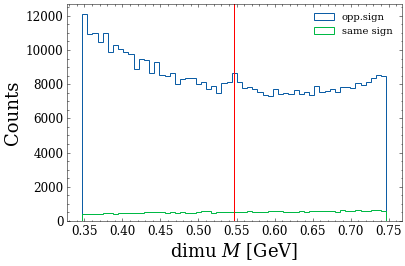

In [6]:
print(np.min(all_data["dimu_mass"]), np.max(all_data["dimu_mass"]))


target_M = 0.547 # GeV
delta = 0.2 #GeV


plt.figure()

plt.hist(all_data["dimu_mass"], bins = np.linspace(target_M - delta, target_M + delta, 60), histtype = "step", label = "opp.sign", density = False)
plt.hist(all_data["dimu_mass_samesign"], bins = np.linspace(target_M - delta, target_M + delta, 60), histtype = "step", label = "same sign", density = False)

plt.axvline(target_M, color = "r")

plt.legend()
plt.ylabel("Counts")
plt.xlabel("dimu $M$ [GeV]")
plt.show()

## Calculate supplementary observables

In [7]:
all_data["mumu_deltaR"] = calculate_deltaR(all_data["mu0_phi"], all_data["mu1_phi"], all_data["mu0_eta"], all_data["mu1_eta"])
all_data["mumu_deltapT"] = all_data["mu0_pt"] - all_data["mu1_pt"]

if run_jet:
    all_data["dimujet_deltaR"] = calculate_deltaR(all_data["dimu_phi"], all_data["hardest_jet_phi"], all_data["dimu_eta"], all_data["hardest_jet_eta"])

if run_samesign:
    all_data["mumu_deltaR_samesign"] = calculate_deltaR(all_data["mu0_phi_samesign"], all_data["mu1_phi_samesign"], all_data["mu0_eta_samesign"], all_data["mu1_eta_samesign"])
    all_data["mumu_deltapT_samesign"] = all_data["mu0_pt_samesign"] - all_data["mu1_pt_samesign"]
    
    if run_jet:
        all_data["dimujet_deltaR_samesign"] = calculate_deltaR(all_data["dimu_phi_samesign"], all_data["hardest_jet_phi_samesign"], all_data["dimu_eta_samesign"], all_data["hardest_jet_eta_samesign"])


Make cuts on deltsaR min

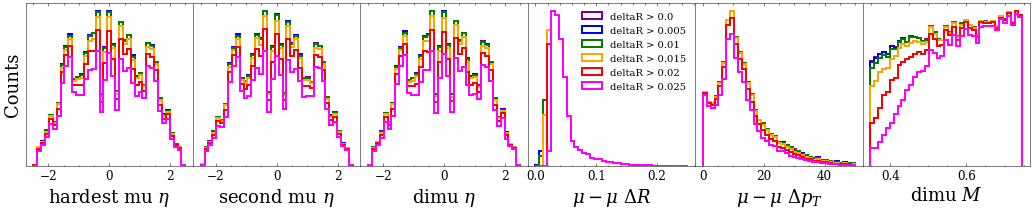

In [8]:
nb = 40
mass_low, mass_high = target_M - delta, target_M + delta

keys_to_plot =  ["mu0_eta", "mu1_eta", "dimu_eta", "mumu_deltaR", "mumu_deltapT", "dimu_mass"]
labels = ["hardest mu $\eta$","second mu $\eta$", "dimu $\eta$", "$\mu-\mu$ $\Delta R$", "$\mu-\mu$ $\Delta p_T$", "dimu $M$"]
bins = [np.linspace(-2.5, 2.5, nb), np.linspace(-2.5, 2.5, nb),np.linspace(-2.5, 2.5, nb), np.linspace(0, .25, nb),np.linspace(0, 50, nb), np.linspace(mass_low, mass_high, nb)]
n_features = len(keys_to_plot)




eta_min, eta_max = -8, 8
event_filter_opp =  (all_data["mumu_deltaR"] > 0.0)  & (all_data["dimu_mass"] > mass_low)  & (all_data["dimu_mass"] < mass_high) & (all_data["mu0_eta"] < eta_max) & (all_data["mu0_eta"] > eta_min)
event_filter_ss =  (all_data["mumu_deltaR_samesign"] > 0.00)  & (all_data["dimu_mass_samesign"] > mass_low)  & (all_data["dimu_mass_samesign"] < mass_high) & (all_data["mu0_eta_samesign"] < eta_max) & (all_data["mu0_eta_samesign"] > eta_min)


colors = ["purple", "blue", "green", "orange", "red", "magenta"]

fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))

for i, key in enumerate(keys_to_plot):
    
    for j, delta_R_min in enumerate([0., 0.005, 0.01, 0.015, 0.02, 0.025]):
    
        event_filter_opp =  (all_data["mumu_deltaR"] >delta_R_min)  & (all_data["dimu_mass"] > mass_low)  & (all_data["dimu_mass"] < mass_high) & (all_data["mu0_eta"] < eta_max) & (all_data["mu0_eta"] > eta_min)
        event_filter_ss =  (all_data["mumu_deltaR_samesign"] > delta_R_min)  & (all_data["dimu_mass_samesign"] > mass_low)  & (all_data["dimu_mass_samesign"] < mass_high) & (all_data["mu0_eta_samesign"] < eta_max) & (all_data["mu0_eta_samesign"] > eta_min)

        if delta_R_min == 0:
            label0 = "opp. sign"
            label1 = "same sign"
        else:
            label0 = None
            label1 = None

        #ax[i].hist(all_data[key][event_filter_opp], bins= bins[i], histtype = "step", label = label0, density = True, color = colors[j])
        ax[i].hist(all_data[key+"_samesign"][event_filter_ss], bins= bins[i], histtype = "step", lw = 2, label = "deltaR > " + str(delta_R_min), density = False, color = colors[j])


 
    ax[i].set_xlabel(labels[i])
    ax[i].set_yticks([])
    
ax[3].legend(fontsize = 10)
ax[0].set_ylabel("Counts")

plt.subplots_adjust(wspace=0)
plt.show()




In [10]:

if run_jet:
    save_id = f"{data_id}_jet"
else: 
    save_id = f"{data_id}_nojet"


with open(f"{path_to_output}/{save_id}", "wb") as output_file:
        pickle.dump(all_data, output_file)
